In [1]:
import time
import numpy as np
import pandas as pd
from scipy.special import softmax
import matplotlib.pyplot as plt
from scipy.special import logsumexp

EARLY_STOP_ACC_TOL = 0.01

# Synthetic Dataset Construction

In [2]:
## Initialize random data (A matrix)
m = 1000 # number of examples
d = 1000 # dim of example
k = 50 # number of output classes
# Data init
A = np.random.normal(0,1,size=(m,d)) # (# examples, dim examples)
# Param init
X = np.random.normal(0,1,size=(d,k)) # (dim examples, # classes)
E = np.random.normal(0,1,size=(m,k)) 
# Generate target classes
#b_i = np.random.randint(1, k+1, size=(m,1))
#b_i_zeroidx = b_i - 1
I_k = np.eye(k)

# This is a kinda strange way of generating data
b = np.dot(A,X) + E # (m,k)
b_i = b.argmax(axis=1) # zero indexed!
b_onehot = I_k[b_i]

# Each model will use the same initial parameters, but different than the ones used to generate the toy data.
X0 = np.random.normal(0,1,size=(d,k))
#X0 = np.zeros_like(X)

In [3]:
# for sanity
num_examples = m
example_dim = d
num_classes = k


# Full Gradient Descent

In [4]:
def grad(A, Y, X):
    Z = - A @ X
    probs = softmax(Z, axis=1)
    m = A.shape[0]
    grad_X = 1/m * (A.T @ (Y - probs))
    return grad_X

def loss(A, Y, X, Z = None):
    Z = - A @ X if Z is None else Z # avoids recalculating
    num_samples = A.shape[0]
    loss = 1/num_samples * (np.trace(A @ X @ Y.T) + np.sum(np.log(np.sum(np.exp(Z), axis=1))))
    return loss

def fast_loss(A, Y, X, Z=None):
    if Z is None:
        Z = -A @ X  # Compute Z only if not provided
    num_samples = A.shape[0]

    # Efficient computation of the trace term
    AX = A @ X
    trace_term = np.sum(AX * Y)

    # Efficient and stable log-sum-exp computation
    log_sum_exp = logsumexp(Z, axis=1)

    # Final computation of the loss
    loss = 1 / num_samples * (trace_term + np.sum(log_sum_exp))
    return loss

def accuracy(X, Z = None):
    Z = - A @ X if Z is None else Z # avoids recalculating
    predictions = softmax(Z)
    predicted_labels = np.argmax(predictions, axis=1)
    actual_labels = b_i #np.argmax(b_onehot, axis=1)
    accuracy = np.mean(predicted_labels == actual_labels)
    return accuracy

def gd(A, b_onehot, max_iter=1000, step_size=0.1):
    X_cur = np.copy(X0)
    start_time_p = time.process_time()
    start_time_w = time.time()
    hist = []
    for i in range(max_iter):
        g = grad(A, b_onehot, X_cur)
        X_cur -= step_size * g
        Z = - A @ X_cur
        # Note that calculating metrics takes CPU time
        # When compairng histories, should calculate roughly the same maetics 
        hist_row = {
            'iter': i,
            'loss': loss(A, b_onehot, X_cur ,Z),
            'accuracy': accuracy(X_cur, Z),
            'grad_mag': np.linalg.norm(g, 2),
            'cpu_time': time.process_time() - start_time_p, # parallization will make this longer than exec time!
            'wall_time': time.time() - start_time_w
            }
        hist.append(hist_row)
        if 1 -  hist_row['accuracy'] < EARLY_STOP_ACC_TOL:
            break

    hist_df = pd.DataFrame(hist)
    return hist_df

In [5]:
hist_gd_df = gd(A,b_onehot, step_size=10)
hist_gd_df

,iter,loss,accuracy,grad_mag,cpu_time,wall_time
0,0,53.813787,0.062,0.272047,0.406250,0.167644
1,1,38.740437,0.137,0.249469,0.484375,0.183883
2,2,26.883508,0.266,0.238383,0.515625,0.197917
3,3,17.658729,0.397,0.216028,0.562500,0.213026
4,4,10.900891,0.557,0.194997,0.718750,0.233209
5,5,6.279336,0.696,0.165659,0.765625,0.250251
6,6,3.283111,0.810,0.136904,0.875000,0.266298
7,7,1.550578,0.898,0.111220,0.968750,0.287350
8,8,0.693544,0.958,0.083838,1.031250,0.305126
9,9,0.326155,0.982,0.061490,1.031250,0.317912


Sources:
https://towardsdatascience.com/multiclass-logistic-regression-from-scratch-9cc0007da372

# BCGD

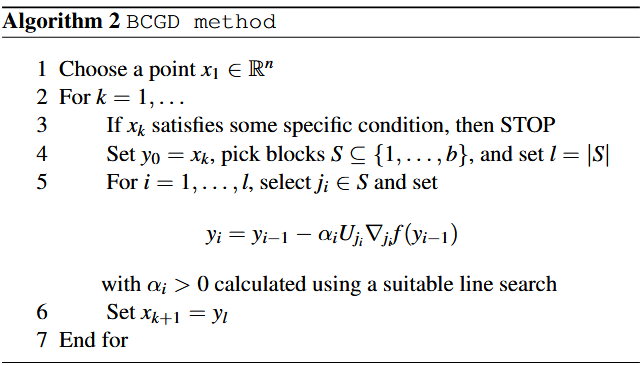

In [7]:
#TODO: calculate lipshitz constant.
L = 0.01
alpha = 1/L

In [8]:
# TODO: implement a faster version that calculates just the ith component
def gs_coord_select(X):
    """"
    Step 4 in the BCGD with GS rule.
    Picks block with maximial gradient
    we select a COORDINATE meaning we get the col of the gradient with biggest magnitude
    Using the full gradeint is more expensive that calculating just a component.
    But is needed here since we need to choose the block of max change
    """
    g = grad(A, b_onehot, X)
    i_k = np.argmax(np.linalg.norm(g, 2, axis = 0)) # select the coord (col)
    g_ik = g[:,i_k].reshape((example_dim,1))
    return g_ik, i_k

def coord_step(X0, i_k, g_ik, alpha=alpha):
    step = - alpha * g_ik
    #X_out = X0
    X0[:,i_k] += step.flatten()
    return {'step_size':alpha}#X_out

def gs_coord_select_T(X):
    """"
    Step 4 in the BCGD with GS rule.
    Picks block with maximial gradient
    we select a COORDINATE meaning we get the col of the gradient with biggest magnitude
    Using the full gradeint is more expensive that calculating just a component.
    But is needed here since we need to choose the block of max change
    """
    g = grad(A, b_onehot, X)
    i_k = np.argmax(np.linalg.norm(g, 2, axis = 1)) # select the coord (row)
    
    g_ik = g[i_k,:].reshape((num_classes,1))
    return g_ik, i_k

def coord_step_T(X0, i_k, g_ik, alpha=alpha):
    step = - alpha * g_ik
    X_out = X0
    X_out[i_k,:] += step.flatten()
    return X_out


# TODO: check optimality condition for early stopping.
def BCGD(coord_select, coord_step=coord_step, max_iter = 100, return_hist = True, step_size = alpha):
    # X_DEBUG = None
    X_cur = np.copy(X0)
    hist = []
    start_time_p = time.process_time()
    start_time_w = time.time()
    for iter in range(max_iter):
        hist_iter = {'iter': iter}
        g_ik, i_k = coord_select(X_cur)
        #X_cur = coord_step(X_cur, i_k, g_ik)
        step_stats = coord_step(X_cur, i_k, g_ik, alpha=step_size)
        # if iter == 5:
        #     X_DEBUG = np.copy(X_cur)
        #     print('whoo')
        if return_hist:
            Z = - A @ X_cur
            hist_iter = {
                'iter': iter,
                'loss': loss(A, b_onehot, X_cur, Z),
                'accuracy': accuracy(X_cur, Z),
                'i_k': i_k,
                'L2_g_ik': np.linalg.norm(g_ik,2),
                'cpu_time': time.process_time() - start_time_p, # parallization will make this longer than exec time!
                'wall_time': time.time() - start_time_w
                }
            hist_iter.update(step_stats)
            hist.append(hist_iter)
            # early stopping
            if 1 - hist_iter['accuracy'] < 0.01:
                break
    if return_hist:
        return pd.DataFrame(hist)#, X_DEBUG
    else:
        return
    
def grad_block(A, Y, X, i_k):
    # used for BCGD with random rule because you dont need full gradient
    Z = -A @ X
    probs = softmax(Z, axis=1)
    m = A.shape[0]
    # Compute only the i_k-th column of the gradient
    grad_X_ik = 1/m * A.T @ (Y[:, i_k] - probs[:, i_k])
    return grad_X_ik

def rand_coord_select(X):
    # TODO: CALCULATING THE FULL GRAD HERE IS NOT NECESSARY
    # [IMPORTANT] it will run faster if this is optimized.
    i_k = np.random.randint(num_classes) # select the coord (col)
    #g = grad(A, b_onehot, X)
    #g_ik = g[:,i_k].reshape((example_dim,1))
    g_ik = grad_block(A, b_onehot, X, i_k)
    return g_ik, i_k

In [9]:
hist_BCGD_GS_df = BCGD(gs_coord_select, max_iter=200, step_size=50)
hist_BCGD_GS_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time,step_size
0,0,70.784910,0.027,21,0.250187,0.218750,0.085546,50
1,1,69.449020,0.035,19,0.240038,0.375000,0.116542,50
2,2,68.056400,0.040,5,0.241708,0.484375,0.137541,50
3,3,66.327433,0.053,8,0.244146,0.593750,0.158552,50
4,4,64.831694,0.063,25,0.237079,0.734375,0.179073,50
...,...,...,...,...,...,...,...,...
125,125,0.064992,0.987,16,0.042959,9.656250,1.932916,50
126,126,0.060608,0.989,0,0.040201,9.781250,1.943917,50
127,127,0.054641,0.989,12,0.038735,9.812500,1.954917,50
128,128,0.047079,0.990,25,0.040077,9.859375,1.968193,50


In [10]:
g_ik, i_k = gs_coord_select(X0)
X_cur = np.copy(X0)
step_size = 0.5
ls_hist = []
for i in range(400):
        step = - g_ik
        last_i = i
        X_cur[:,i_k] += step_size * step.flatten()
        l = loss(A,b_onehot, X_cur)#
        ls_hist.append({'step':0,'loss':l,'step_size':step_size*i})
ls_hist = pd.DataFrame(ls_hist)
ls_hist

,step,loss,step_size
0,0,72.643526,0.0
1,0,72.612548,0.5
2,0,72.581854,1.0
3,0,72.551498,1.5
4,0,72.521517,2.0
...,...,...,...
395,0,72.456015,197.5
396,0,72.473077,198.0
397,0,72.490209,198.5
398,0,72.507410,199.0


Text(0.5, 1.0, 'Loss vs stepsize over Block Line Search')

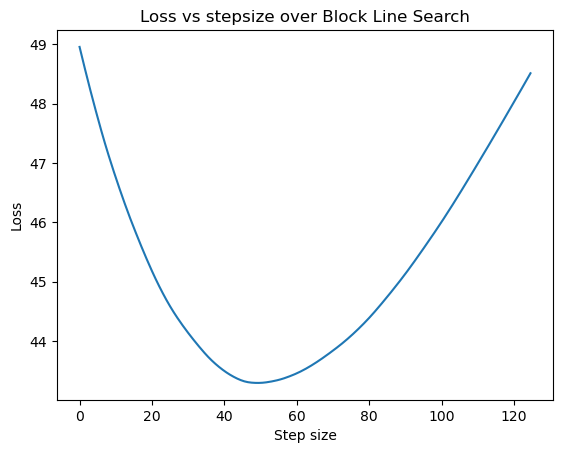

In [83]:
# plot for writeup
plt.plot(ls_hist['step_size'][:250], ls_hist['loss'][:250])
plt.xlabel('Step size')
plt.ylabel('Loss')
plt.title('Loss vs stepsize over Block Line Search')

In [11]:
def coord_step_linesearch(X_cur, i_k, g_ik, alpha:float):
    #hist_ls = []
    prev_loss = 1e10
    last_i = 0
    for i in range(100):
        step = - g_ik
        last_i = i
        X_cur[:,i_k] += alpha * step.flatten()
        l = fast_loss(A,b_onehot, X_cur)#
        # hist_ls.append({
        #     'iter': i,
        #     'loss': l
        # })
        if l > prev_loss:
            # by convexity, if the loss increases along our line search, stop searching.
            X_cur[:,i_k] -= alpha * step.flatten() # this is wastful: undoing work, but probably better than maintining the last X in memory
            break
        prev_loss = l
# ls_df = pd.DataFrame(hist_ls)
# ls_df
    return {'step_size': alpha * last_i, 'ls_steps':last_i}

In [16]:
hist_BCGD_GS_ls_df = BCGD(gs_coord_select, coord_step=coord_step_linesearch, max_iter=100, step_size=5)
hist_BCGD_GS_ls_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time,step_size,ls_steps
0,0,69.545816,0.039,8,0.260604,1.296875,0.270859,85,17
1,1,67.442374,0.066,16,0.241867,2.250000,0.499915,110,22
2,2,65.091393,0.087,29,0.243855,3.343750,0.679661,90,18
3,3,63.105823,0.109,11,0.238175,4.359375,0.865717,90,18
4,4,61.042762,0.132,30,0.237184,5.406250,1.066899,95,19
...,...,...,...,...,...,...,...,...,...
74,74,0.241348,0.984,33,0.047723,45.828125,9.045388,35,7
75,75,0.216904,0.986,21,0.047946,46.031250,9.102674,35,7
76,76,0.189037,0.987,12,0.045996,46.265625,9.152674,30,6
77,77,0.171564,0.988,41,0.043865,46.703125,9.230332,55,11


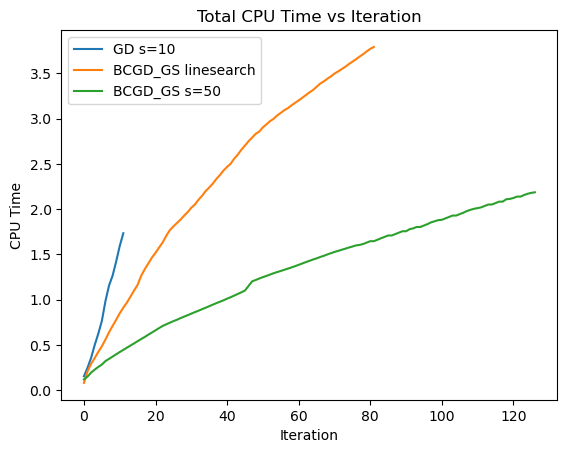

In [171]:
plt.plot(hist_gd_df['iter'], hist_gd_df['cpu_time'], label='GD s=10')
plt.plot(hist_BCGD_GS_ls_df['iter'],hist_BCGD_GS_ls_df['wall_time'], label='BCGD_GS linesearch')
plt.plot(hist_BCGD_GS_df['iter'],hist_BCGD_GS_df['wall_time'], label='BCGD_GS s=50')
plt.title('Total CPU Time vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('CPU Time')
plt.legend()

In [155]:
X0.shape

(1000, 50)

In [87]:
hist_BCGD_GS_ls_df['ls_steps'].mean()

5.217391304347826

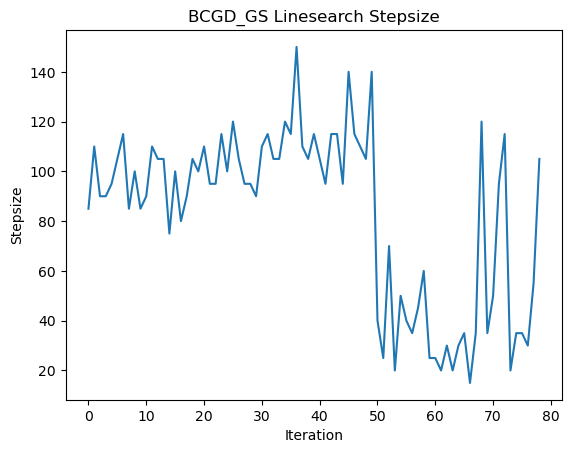

In [20]:
plt.plot(hist_BCGD_GS_ls_df['iter'], hist_BCGD_GS_ls_df['step_size'])
plt.xlabel('Iteration')
plt.ylabel('Stepsize')
plt.title('BCGD_GS Linesearch Stepsize')
plt.show()

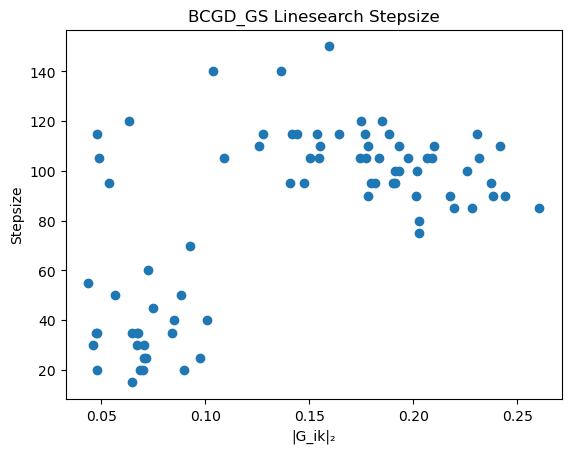

In [21]:
plt.scatter(hist_BCGD_GS_ls_df['L2_g_ik'], hist_BCGD_GS_ls_df['step_size'])
plt.xlabel('|G_ik|₂')
plt.ylabel('Stepsize')
plt.title('BCGD_GS Linesearch Stepsize')
plt.show()

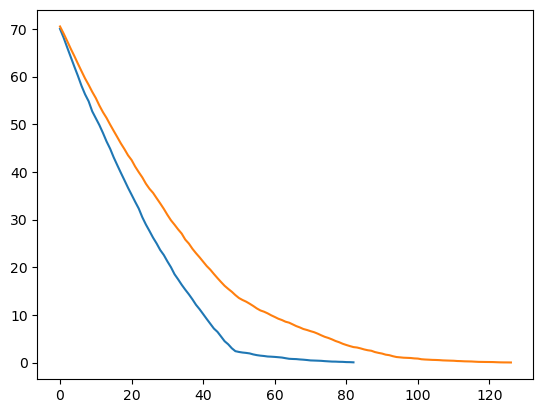

In [181]:
plt.figure()
plt.plot(hist_BCGD_GS_ls_df['iter'], hist_BCGD_GS_ls_df['loss'])
plt.plot(hist_BCGD_GS_df['iter'], hist_BCGD_GS_df['loss'])

In [99]:
ls_df['loss'].plot()

NameError: name 'ls_df' is not defined

In [173]:
hist_BCGD_rand_df = BCGD(rand_coord_select, max_iter=500, step_size=50)
hist_BCGD_rand_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time,step_size
0,0,70.636297,0.023,35,0.242122,0.125000,0.030964,50
1,1,69.152505,0.031,48,0.224825,0.375000,0.060967,50
2,2,68.057172,0.036,11,0.202198,0.453125,0.087966,50
3,3,66.479289,0.048,17,0.240581,0.640625,0.115978,50
4,4,65.587487,0.053,42,0.199277,0.734375,0.142498,50
...,...,...,...,...,...,...,...,...
288,288,0.211306,0.989,4,0.000862,25.218750,4.471029,50
289,289,0.200740,0.990,44,0.043822,25.296875,4.486398,50
290,290,0.192373,0.990,2,0.031557,25.421875,4.499400,50
291,291,0.191823,0.990,15,0.013017,25.531250,4.514406,50


In [137]:
def plot_hist(X_val, Y_val, dfs, legend_lables):
    # Checking optimality conditions
    # want to plot only the histories before cond. met.

    fig = plt.figure()
    for i, hist_df in enumerate(dfs):
        plt.plot(hist_df[X_val], hist_df[Y_val], label=legend_lables[i])
    # plt.plot(hist_gd_df[gd_sele][X_val], hist_gd_df[gd_sele][Y_val], label='GD')
    # plt.plot(hist_BCGD_GS_df[gs_sele][X_val], hist_BCGD_GS_df[gs_sele][Y_val], label='GS')
    # plt.plot(hist_BCGD_rand_df[rand_sele][X_val], hist_BCGD_rand_df[rand_sele][Y_val], label = 'Random')
    plt.legend()
    plt.xlabel(X_val)
    plt.ylabel(Y_val)
    plt.show()

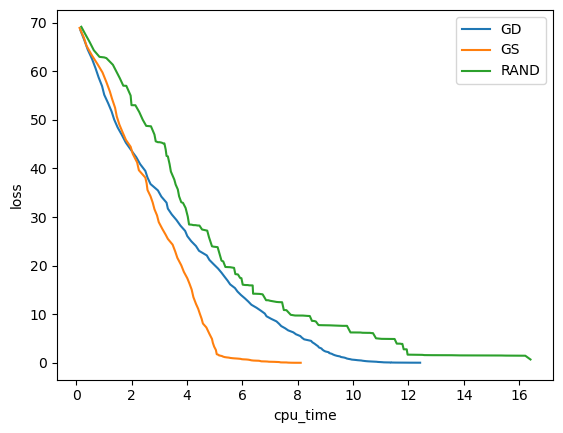

In [138]:
gd_sele = (hist_gd_df['grad_mag'] < 0.01).cumsum() == 0
gs_sele = (hist_BCGD_GS_df['L2_g_ik'] < 0.01).cumsum() == 0
rand_sele = (hist_BCGD_rand_df['L2_g_ik'] < 0.01).cumsum() < 30 # patience for random because prev. selected coords have low grad and can stop prematurely.
plot_hist('cpu_time', 'loss', [hist_gd_df[gd_sele], hist_BCGD_GS_df[gs_sele], hist_BCGD_rand_df[rand_sele]], ['GD', 'GS', 'RAND'])

In [47]:
import timeit

grad_times = []
for i in range(100):
    p_start = time.process_time()#timeit.timeit()
    w_start = time.time()
    grad(A,b_onehot,X0)
    p_end = time.process_time()#timeit.timeit()
    w_end = time.time()
    grad_times.append({'p_time':p_end-p_start, 'w_time':w_end-w_start})
grad_times = pd.DataFrame(grad_times)
grad_times.mean()

p_time    0.043437
w_time    0.008877
dtype: float64

In [46]:
block_times = []
for i in range(100):
    p_start = time.process_time()#timeit.timeit()
    w_start = time.time()
    grad_block(A,b_onehot,X0, 4)
    p_end = time.process_time()#timeit.timeit()
    w_end = time.time()
    block_times.append({'p_time':p_end-p_start, 'w_time':w_end-w_start})
block_times = pd.DataFrame(block_times)
block_times.mean()

p_time    0.062656
w_time    0.010988
dtype: float64

In [49]:
loss_times = []
for i in range(100):
    p_start = time.process_time()#timeit.timeit()
    w_start = time.time()
    loss(A,b_onehot,X0)
    p_end = time.process_time()#timeit.timeit()
    w_end = time.time()
    loss_times.append({'p_time':p_end-p_start, 'w_time':w_end-w_start})
loss_times = pd.DataFrame(loss_times)
loss_times.mean()

p_time    0.060781
w_time    0.011807
dtype: float64

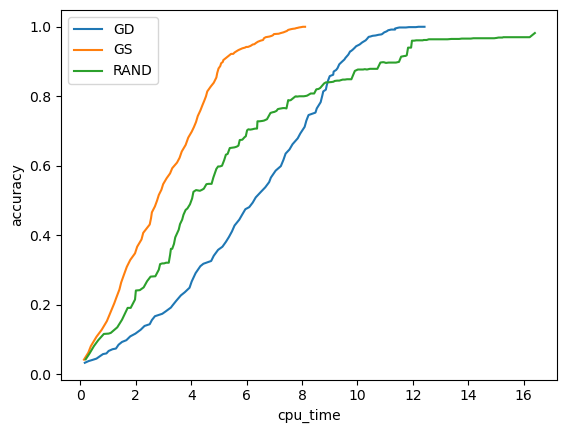

In [139]:
plot_hist('cpu_time', 'accuracy', [hist_gd_df[gd_sele], hist_BCGD_GS_df[gs_sele], hist_BCGD_rand_df[rand_sele]], ['GD', 'GS', 'RAND'])

In [140]:
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import OneHotEncoder
iris = fetch_ucirepo(id=53) 
A_df = iris.data.features 
class_df = iris.data.targets 

In [141]:
b_names = class_df['class'].to_numpy().reshape(-1,1) # rows are examples
b_cat_names = class_df['class'].unique()
b_cat_names

OH_encoder = OneHotEncoder(sparse=False)
b_onehot = OH_encoder.fit_transform(b_names)
b_i = np.argmax(b_onehot, axis=1) # number corresponding to the class
A = A_df.to_numpy(dtype=float)
num_examples, example_dim = A.shape
num_classes = len(b_cat_names)
X0 = np.random.normal(0,1,size=(example_dim,num_classes))

c:\Source\Anaconda\envs\Frank\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [150]:
gd_iris_df = gd(A, b_onehot, eta = 0.05)
gd_iris_df

,iter,loss,accuracy,grad_mag,cpu_time,wall_time
0,0,7.035553,0.333333,7.047432,0.015625,0.012557
1,1,4.558378,0.333333,7.044138,0.031250,0.022314
2,2,2.234714,0.333333,6.987934,0.031250,0.023650
3,3,1.238078,0.566667,5.771684,0.031250,0.023650
4,4,0.930227,0.606667,2.821333,0.031250,0.024658
...,...,...,...,...,...,...
995,995,0.178251,0.960000,0.040241,1.359375,0.323812
996,996,0.178169,0.960000,0.040209,1.359375,0.323812
997,997,0.178086,0.960000,0.040178,1.359375,0.323812
998,998,0.178003,0.960000,0.040147,1.359375,0.323812


In [156]:
bcgd_gs_iris_df = BCGD(gs_coord_select, step_size=0.1, max_iter=1000)
bcgd_gs_iris_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,6.217491,0.333333,0,5.747779,0.000000,0.001000
1,1,2.961818,0.333333,0,5.741439,0.000000,0.008064
2,2,1.154846,0.326667,0,5.428457,0.000000,0.009106
3,3,0.917601,0.253333,1,1.941350,0.031250,0.009106
4,4,0.878882,0.666667,2,0.819899,0.031250,0.010146
...,...,...,...,...,...,...,...
995,995,0.174593,0.953333,2,0.028601,1.796875,0.374990
996,996,0.174511,0.953333,2,0.028570,1.828125,0.374990
997,997,0.174430,0.953333,2,0.028539,1.828125,0.374990
998,998,0.174348,0.953333,0,0.028533,1.843750,0.375990


In [163]:
bcgd_rand_iris_df = BCGD(rand_coord_select, step_size=0.1, max_iter=500)
bcgd_rand_iris_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,8.551884,0.333333,2,3.112061,0.000000,0.001749
1,1,7.584707,0.333333,2,3.111076,0.000000,0.002607
2,2,4.339738,0.333333,0,5.740180,0.000000,0.002607
3,3,3.642264,0.333333,1,2.641419,0.000000,0.007038
4,4,2.947723,0.333333,1,2.638836,0.000000,0.007038
...,...,...,...,...,...,...,...
495,495,0.294265,0.946667,0,0.044693,0.640625,0.147393
496,496,0.294069,0.946667,0,0.044370,0.640625,0.147393
497,497,0.293613,0.946667,2,0.067595,0.640625,0.147393
498,498,0.293538,0.946667,1,0.027815,0.640625,0.148756


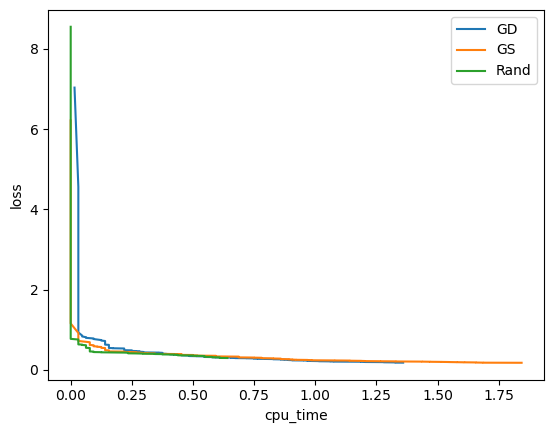

In [164]:
plot_hist('cpu_time', 'loss', [gd_iris_df, bcgd_gs_iris_df, bcgd_rand_iris_df], legend_lables=['GD', 'GS', 'Rand'])

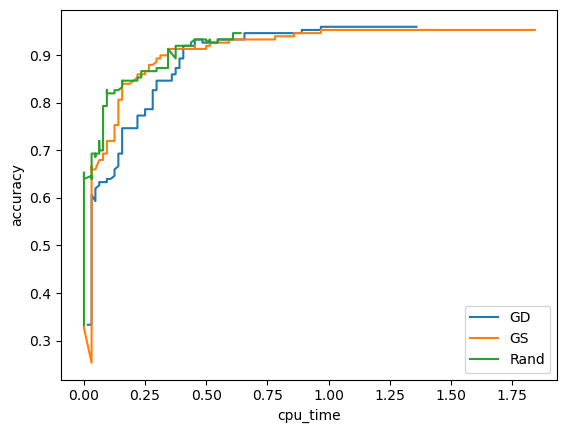

In [168]:
plot_hist('cpu_time', 'accuracy', [gd_iris_df, bcgd_gs_iris_df, bcgd_rand_iris_df], legend_lables=['GD', 'GS', 'Rand'])

In [174]:
from sklearn.preprocessing import StandardScaler
wine = fetch_ucirepo(id=109) 
  
# data (as pandas dataframes) 
wine_feats_df = wine.data.features 
wine_target_df = wine.data.targets 

scaler = StandardScaler()
wine_feats_df = pd.DataFrame(scaler.fit_transform(wine_feats_df), columns=wine_feats_df.columns)

In [175]:
wine_feats_df

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.876275,2.974543,0.305159,0.301803,-0.332922,-0.985614,-1.424900,1.274310,-0.930179,1.142811,-1.392758,-1.231206,-0.021952
174,0.493343,1.412609,0.414820,1.052516,0.158572,-0.793334,-1.284344,0.549108,-0.316950,0.969783,-1.129518,-1.485445,0.009893
175,0.332758,1.744744,-0.389355,0.151661,1.422412,-1.129824,-1.344582,0.549108,-0.422075,2.224236,-1.612125,-1.485445,0.280575
176,0.209232,0.227694,0.012732,0.151661,1.422412,-1.033684,-1.354622,1.354888,-0.229346,1.834923,-1.568252,-1.400699,0.296498


In [176]:
wine_target_df

,class
0,1
1,1
2,1
3,1
4,1
...,...
173,3
174,3
175,3
176,3


In [177]:

b_names = wine_target_df['class'].to_numpy().reshape(-1,1) # rows are examples
b_cat_names = wine_target_df['class'].unique()
b_cat_names

OH_encoder = OneHotEncoder(sparse=False)
b_onehot = OH_encoder.fit_transform(b_names)
b_i = np.argmax(b_onehot, axis=1) # number corresponding to the class
A = wine_feats_df.to_numpy(dtype=float)
num_examples, example_dim = A.shape
num_classes = len(b_cat_names)
X0 = np.random.normal(0,1,size=(example_dim,num_classes))

c:\Source\Anaconda\envs\Frank\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [188]:
wine_gd_df = gd(A, b_onehot, eta=5, max_iter=100)
wine_gd_df

,iter,loss,accuracy,grad_mag,cpu_time,wall_time
0,0,0.196444,0.932584,1.007084,0.031250,0.003994
1,1,0.068951,0.977528,0.196301,0.031250,0.005203
2,2,0.048269,0.983146,0.061720,0.031250,0.007256
3,3,0.038160,0.983146,0.036605,0.046875,0.011707
4,4,0.032089,0.988764,0.028515,0.046875,0.012752
...,...,...,...,...,...,...
95,95,0.005329,1.000000,0.002165,0.359375,0.066142
96,96,0.005293,1.000000,0.002149,0.359375,0.067144
97,97,0.005258,1.000000,0.002133,0.375000,0.067144
98,98,0.005223,1.000000,0.002117,0.390625,0.068142


In [210]:
wine_bcgd_gs_df = BCGD(gs_coord_select, coord_step)#(A, b_onehot, eta=1, max_iter=100)
wine_bcgd_gs_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,22.109878,0.719101,1,0.820918,0.000000,0.020375
1,1,2.190292,0.898876,1,0.745920,0.000000,0.021426
2,2,0.508645,0.971910,0,0.229086,0.000000,0.021426
3,3,0.220714,0.971910,1,0.054003,0.000000,0.022460
4,4,0.102552,0.983146,1,0.049310,0.000000,0.022460
...,...,...,...,...,...,...,...
95,95,0.000226,1.000000,2,0.000152,0.234375,0.103369
96,96,0.000223,1.000000,0,0.000150,0.234375,0.103369
97,97,0.000221,1.000000,2,0.000148,0.234375,0.103369
98,98,0.000219,1.000000,1,0.000147,0.234375,0.103369


In [203]:
wine_bcgd_rand_df = BCGD(rand_coord_select, coord_step)#(A, b_onehot, eta=1, max_iter=100)
wine_bcgd_rand_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,22.109878,0.719101,1,0.820918,0.000000,0.012181
1,1,2.190292,0.898876,1,0.745920,0.000000,0.013211
2,2,2.141342,0.926966,2,0.117418,0.000000,0.013211
3,3,0.920150,0.960674,0,0.132137,0.000000,0.014242
4,4,0.445210,0.971910,1,0.072870,0.015625,0.014242
...,...,...,...,...,...,...,...
95,95,0.000195,1.000000,2,0.000147,0.281250,0.083355
96,96,0.000193,1.000000,0,0.000150,0.281250,0.083355
97,97,0.000190,1.000000,0,0.000146,0.281250,0.083355
98,98,0.000189,1.000000,1,0.000119,0.281250,0.083355


In [204]:
wine_bcgd_rand_df.iloc[:12]

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,22.109878,0.719101,1,0.820918,0.000000,0.012181
1,1,2.190292,0.898876,1,0.745920,0.000000,0.013211
2,2,2.141342,0.926966,2,0.117418,0.000000,0.013211
3,3,0.920150,0.960674,0,0.132137,0.000000,0.014242
4,4,0.445210,0.971910,1,0.072870,0.015625,0.014242
5,5,0.372025,0.971910,2,0.027113,0.015625,0.015276
6,6,0.341100,0.977528,2,0.026338,0.015625,0.015276
7,7,0.219683,0.977528,0,0.035026,0.015625,0.015276
8,8,0.104836,0.977528,0,0.034560,0.031250,0.016419
9,9,0.101377,0.977528,2,0.015240,0.031250,0.017427


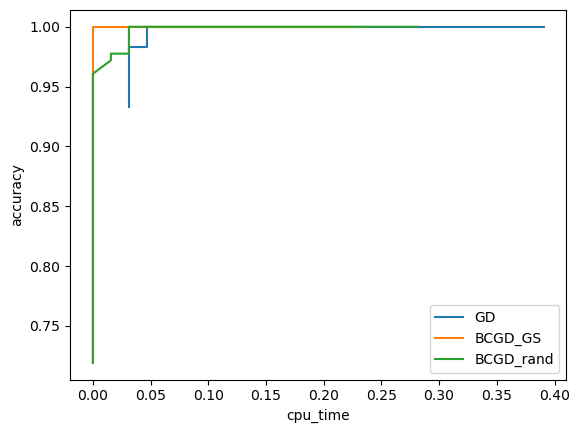

In [211]:
plot_hist('cpu_time', 'accuracy', [wine_gd_df, wine_bcgd_gs_df, wine_bcgd_rand_df], ['GD', 'BCGD_GS', 'BCGD_rand'])

In [435]:
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80) 
  
# data (as pandas dataframes) 
digits_feats_df = optical_recognition_of_handwritten_digits.data.features / 16
digits_target_df = optical_recognition_of_handwritten_digits.data.targets 
 
digits_mask = digits_target_df['class'].isin([0,1,2,3,4])
digits_feats_df = digits_feats_df[digits_mask]
digits_target_df = digits_target_df[digits_mask]

In [408]:
digits_target_df

,class
0,0
1,0
8,0
9,8
11,1
...,...
5612,8
5613,8
5616,0
5617,8


In [436]:
b_names = digits_target_df['class'].to_numpy().reshape(-1,1) # rows are examples
b_cat_names = digits_target_df['class'].unique()
b_cat_names

OH_encoder = OneHotEncoder(sparse=False)
b_onehot = OH_encoder.fit_transform(b_names)
b_i = np.argmax(b_onehot, axis=1) # number corresponding to the class
A = digits_feats_df.to_numpy(dtype=float)
num_examples, example_dim = A.shape
num_classes = len(b_cat_names)
X0 = np.random.normal(0,1,size=(example_dim,num_classes))

c:\Source\Anaconda\envs\Frank\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [454]:
digits_gd_df = gd(A,b_onehot, max_iter=100, eta=3.0)

In [472]:
digits_bcgd_gs_df = BCGD(gs_coord_select, step_size=2)

In [474]:
digits_bcgd_gst_df = BCGD(gs_coord_select_T, step_size=2)

AxisError: axis 1 is out of bounds for array of dimension 1

In [469]:
g = grad(A, b_onehot, X0)
g.shape

(64, 5)

In [471]:
gs_coord_select_T(X0)

(array([[ 0.10937516],
        [-0.11947757],
        [ 0.15122088],
        [-0.28603662],
        [ 0.14491815]]),
 11)

In [439]:
digits_bcgd_rand_df = BCGD(rand_coord_select, step_size=3)

In [448]:
digits_bcgd_gsls_df = BCGD(gs_coord_select,coord_step=coord_step_linesearch, step_size=0.1)

In [457]:
digits_bcgd_randls_df = BCGD(rand_coord_select,coord_step=coord_step_linesearch, step_size=0.1)

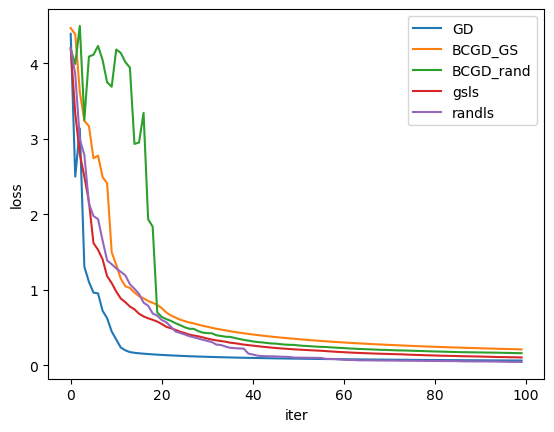

In [463]:
plot_hist('iter', 'loss', [digits_gd_df, digits_bcgd_gs_df, digits_bcgd_rand_df, digits_bcgd_gsls_df,digits_bcgd_randls_df], ['GD', 'BCGD_GS', 'BCGD_rand', 'gsls', 'randls'])

<Axes: >

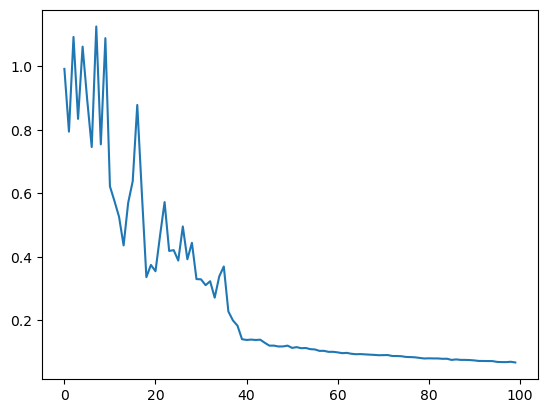

In [372]:
digits_bcgd_gs_df['L2_g_ik'].plot()

In [54]:
#grad(A, b_onehot, np.random.randn(0,1))
#L = []
#L_block = []
#L_block_norm = []
vars = [1]#, 0.5, 0.25, 0.1]
L_hist = []
for cur_var in vars:
    for i in range(100):
        X_rand = np.random.normal(0,0.5,size=(example_dim,num_classes))
        Y_rand = np.random.normal(0,0.5,size=(example_dim,num_classes))
        X_grad = grad(A, b_onehot, X_rand)
        Y_grad = grad(A, b_onehot, Y_rand)
        L_full = np.linalg.norm(X_grad - Y_grad,2)/np.linalg.norm(X_rand - Y_rand,2)
        #L.append(L_full)
        block_idx = np.random.randint(num_classes)
        X_grad_rand = grad_block(A, b_onehot, X_rand, block_idx)
        Y_grad_rand = grad_block(A, b_onehot, Y_rand, block_idx)
        X_grad_rand = grad_block(A, b_onehot, X_rand, block_idx)
        Y_grad_rand = grad_block(A, b_onehot, Y_rand, block_idx)
        L_block = np.linalg.norm(X_grad_rand - Y_grad_rand,2)/np.linalg.norm(X_rand - Y_rand,2)
        L_hist.append({'i':i, 'var':cur_var, 'L_full':L_full, 'block_idx':block_idx, 'L_block':L_block})
L_hist = pd.DataFrame(L_hist)

In [60]:
1 / L_hist['L_block'].mean()

144.16042123643118

In [50]:
1/max(L_block)

NameError: name 'L_block' is not defined

In [380]:
A.shape

(5620, 64)